# Contextual Meta-Bandit for Recommender Systems Selection

In [1]:
import sys, os
import plotly.graph_objects as go
import numpy as np

sys.path.insert(0, "/media/workspace/DeepFood/deep-reco-gym/tools/eval_viz")
import pandas as pd
import argparse
import copy
import numpy as np
import os
import random
import json
from pandas.io.json import json_normalize
from app import fetch_iteraction_results_path, load_all_iteraction_metrics
from app import load_iteractions_params as load_iteractions_params2, PATH_EVAL_REINFORCEMENT
from plot import plot_line_iteraction, plot_exploration_arm, get_colors, confidence
import pandas as pd
import argparse
import copy
import numpy as np
import streamlit as st
import seaborn as sns
sns.set(style="darkgrid")
#sys.path.insert(0, os.path.dirname(__file__))
import matplotlib.pyplot as plt
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path


In [2]:
models_and_legend = {
  "____remote_":           ["bandit_policy", "obs"],
}
path = PATH_EVAL_REINFORCEMENT

In [3]:
models_and_legend

{'____remote_': ['bandit_policy', 'obs']}

In [4]:
def list_paths_per_model(input_path):
    models = []
    
    for model, legend in models_and_legend.items():
    #print(model)
    #print(legend)
        for root, dirs, files in os.walk(input_path):
            if '/results' in root and 'Interaction' in root:
                for d in dirs:
                    #print(os.path.join(root, d))
                    if model in d:
                        models.append(os.path.join(root, d))
    return models

def load_iteractions_params(iteractions):
  if len(iteractions) == 0:
    return pd.DataFrame()

  dfs = []

  for model in iteractions:

    file_path = os.path.join(model, 'params.json')
    data      = []

    #try:
    with open(file_path) as json_file:
        d = json.load(json_file)
        data.append(d)

        df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')
      
    #except:
    #  df = pd.DataFrame()

    df['iteraction'] = model
    dfs.append(df)
  
  return pd.concat(dfs)


def load_data_iteractions_metrics(path, sample_size = 10000):
    random.seed(42)
    file      = os.path.join(path,'sim-datalog.csv')

    # Count the lines
    num_lines = sum(1 for l in open(file)) - 1

    # Sample size - in this case ~10%
    size = np.min([sample_size, num_lines])#int(num_lines / 10)

    # The row indices to skip - make sure 0 is not included to keep the header!
    skip_idx  = sorted(random.sample(range(1, num_lines), num_lines - size))
    idx       = list(set(list(range(num_lines))) - set(skip_idx))

    df        = pd.read_csv(file, skiprows=skip_idx)
    
    df        = pd.read_csv(file)#.reset_index()
    idx       = list(range(len(df)))

    df['idx'] = sorted(idx)
    df        = df.sort_values("idx")
    return df


def get_metrics_reward(bandits):
    data    = []
    for i, p in enumerate(bandits):
        df_metrics = load_data_iteractions_metrics(p)
        r_mean     = df_metrics.reward.mean()
        r_reward   = df_metrics.reward.sum()
        data.append((i, r_mean, r_reward))
    df_metrics = pd.DataFrame(data, columns=['idx', 'r_mean', 'r_reward']).set_index('idx')    
    return df_metrics

def group_metrics(df):
    df_g_metrics = df.groupby('bandit').agg({'r_mean': ['mean', 'std'], 'r_reward': ['mean', 'std', 'count'], 'model': 'first' })
    df_g_metrics.columns = df_g_metrics.columns.map(lambda x: '|'.join([str(i) for i in x]))
    return df_g_metrics    
    
result_paths = list_paths_per_model(path)
#result_paths

In [5]:
fetch_results_path()

{}

## Filter and Group Results per Bandit

In [6]:
df_params = load_iteractions_params(result_paths)
df_params.head()

/home/marlesson/anaconda3/envs/deep-reco-gym/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,balance_fields,bandit_policy,bandit_policy_params.c,bandit_policy_params.endpoints,bandit_policy_params.epsilon,bandit_policy_params.logit_multiplier,bandit_policy_params.window_reward,batch_size,dataset_split_method,device,...,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,user_column,user_idx_column,val_size,val_split_type
0,[],remote_contextual_softmax,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,10.0,NaN,500,time,cuda,...,13,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.10,NaN,NaN,500,time,cuda,...,12,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.05,NaN,NaN,500,time,cuda,...,13,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.05,NaN,NaN,500,time,cuda,...,11,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.20,NaN,NaN,500,time,cuda,...,10,0.1,0,0.0,time,False,account_id,account_idx,0.0,time


In [7]:
df_params.obs.unique()

array(['[Contextual]Softmax-10 13', '[CONTEXTUAL]e-greedy-0.05 12',
       '[CONTEXTUAL]e-greedy-0.05 13', '[CONTEXTUAL]e-greedy-0.05 11',
       '[CONTEXTUAL]e-greedy-0.05 10', '[MAB]e-greedy-0.05 16',
       '[MAB]UCB-5  11', '[MAB]UCB-10-10000  2', '[MAB]UCB-1-10000  1',
       '[MAB]UCB-10  11', '[MAB]e-greedy-0.2 12',
       '[Contextual]Softmax-50 14', '[Contextual]Softmax-100 11',
       '[MAB]e-greedy-0.2 10', '[MAB]e-greedy-0.2 14',
       '[MAB]e-greedy-0.1 10', '[Contextual]Softmax-500 10',
       '[CONTEXTUAL]e-greedy-0.05 14', '[MAB]e-greedy-0.1 16',
       '[MAB]e-greedy-0.05 11', '[Contextual]Softmax-10 16',
       '[Contextual]Softmax-500 14', '[MAB]e-greedy-0.05 12',
       '[Contextual]Softmax-500 11', '[MAB]UCB-1  11', 'CDAE',
       '[Contextual]Softmax-50 13', '[MAB]e-greedy-0.2 13',
       '[Contextual]Softmax-10 11', '[MAB]e-greedy-0.05 10',
       'MostPopular', '[Contextual]Softmax-50 11',
       '[Contextual]Softmax-50 10', '[Contextual]Softmax-10 14',
       

In [8]:
df_params['obs'].apply(lambda x: " ".join(x.split(" ")[:-1]).strip()).unique()

array(['[Contextual]Softmax-10', '[CONTEXTUAL]e-greedy-0.05',
       '[MAB]e-greedy-0.05', '[MAB]UCB-5', '[MAB]UCB-10-10000',
       '[MAB]UCB-1-10000', '[MAB]UCB-10', '[MAB]e-greedy-0.2',
       '[Contextual]Softmax-50', '[Contextual]Softmax-100',
       '[MAB]e-greedy-0.1', '[Contextual]Softmax-500', '[MAB]UCB-1', '',
       '[MAB]UCB-5-10000'], dtype=object)

In [9]:
df_params
df_params['observation'] = df_params['bandit_policy_params.epsilon'].apply(str)+df_params['obs']# .apply(lambda x: " ".join(x.split(" ")[:-2]))
df_params['observation'] = df_params['observation'].apply(lambda x: " ".join(x.split(" ")[:-1]) if len(x.split(" ")) > 1 else x)
df_params['observation'].unique()

array(['nan[Contextual]Softmax-10', '0.1[CONTEXTUAL]e-greedy-0.05',
       '0.05[CONTEXTUAL]e-greedy-0.05', '0.2[CONTEXTUAL]e-greedy-0.05',
       '0.05[MAB]e-greedy-0.05', 'nan[MAB]UCB-5 ',
       'nan[MAB]UCB-10-10000 ', 'nan[MAB]UCB-1-10000 ', 'nan[MAB]UCB-10 ',
       '0.2[MAB]e-greedy-0.2', 'nan[Contextual]Softmax-50',
       'nan[Contextual]Softmax-100', '0.1[MAB]e-greedy-0.1',
       'nan[Contextual]Softmax-500', 'nan[MAB]UCB-1 ', 'nanCDAE',
       'nanMostPopular', 'nanMatrixFactorization', '0.05teste', 'nanCVAE',
       'nan[MAB]UCB-5-10000 ', 'nanRandom'], dtype=object)

In [10]:
list_bandits          = df_params.groupby(["bandit_policy", "observation"])['iteraction'].apply(list).reset_index()
list_bandits['name']  = list_bandits.bandit_policy.map(str) + ' ' + list_bandits.observation.map(str)
list_bandits['name']  = list_bandits['name'].apply(lambda x: x.replace("fixed ", "").replace(" ", ""))
list_bandits['model'] = list_bandits.iteraction.apply(lambda l: l[np.random.randint(0, len(l))])
list_bandits['model_list'] = list_bandits.iteraction
list_bandits

,bandit_policy,observation,iteraction,name,model,model_list
0,remote,nanCDAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6],remotenanCDAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6]
1,remote,nanCVAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920],remotenanCVAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920]
2,remote,nanMatrixFactorization,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b],remotenanMatrixFactorization,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b]
3,remote,nanMostPopular,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a],remotenanMostPopular,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a]
4,remote,nanRandom,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7],remotenanRandom,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7]
5,remote_contextual_epsilon_greedy,0.05[CONTEXTUAL]e-greedy-0.05,"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______09ec6475d3, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______6d792a3ed1, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______afb131bbc0, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______675b43b6a5, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______2c656f2636, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______4184b0299f, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______a0d520e892]",remote_contextual_epsilon_greedy0.05[CONTEXTUAL]e-greedy-0.05,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______675b43b6a5,"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______09ec6475d3, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______6d792a3ed1, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______afb131bbc0, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______675b43b6a5, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______2c656f2636, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______4184b0299f, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______a0d520e892]"
6,remote_contextual_epsilon_greedy,0.1[CONTEXTUAL]e-greedy-0.05,"[output/interaction/Ensam

In [11]:
#df_params

### Group Results per Bandit

In [12]:
list_bandits.head(2)

,bandit_policy,observation,iteraction,name,model,model_list
0,remote,nanCDAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6],remotenanCDAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6]
1,remote,nanCVAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920],remotenanCVAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920]


In [13]:
reward_metrics = []

for i, row in list_bandits.iterrows():
    try:
        df_metrics = get_metrics_reward(row['iteraction'])
        
        df_metrics['bandit'] = str(row['bandit_policy']) + " " + str(row['observation'])
        df_metrics['model']  = row['model']

        df_g_metrics = group_metrics(df_metrics)
        reward_metrics.append(df_g_metrics)
    except FileNotFoundError:
        pass

In [14]:
df_all = pd.concat(reward_metrics)
df_all = df_all.reset_index().sort_values('bandit', ascending=False).set_index('bandit')
df_all

,r_mean|mean,r_mean|std,r_reward|mean,r_reward|std,r_reward|count,model|first
bandit,,,,,,
remote_ucb nan[MAB]UCB-5-10000,0.121764,NaN,1397.000000,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______5559c61cfe
remote_ucb nan[MAB]UCB-5,0.116273,0.000000,1334.000000,0.000000,3,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______c96b9331ac
remote_ucb nan[MAB]UCB-10-10000,0.126558,NaN,1452.000000,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______c6ad4386c3
remote_ucb nan[MAB]UCB-10,0.113222,0.000000,1299.000000,0.000000,2,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______7e7848f84c
remote_ucb nan[MAB]UCB-1-10000,0.118801,NaN,1363.000000,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______78b0b601e8
remote_ucb nan[MAB]UCB-1,0.113571,0.000000,1303.000000,0.000000,3,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______ad84e1b2a4
remote_epsilon_greedy 0.2[MAB]e-greedy-0.2,0.108379,0.002816,1243.428571,32.310252,7,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______e629c0a750
remote_epsilon_greedy 0.1[MAB]e-greedy-0.1,0.108167,0.002719,1241.000000,31.192948,7,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______f21e3b0cdb
remote_epsilon_greedy 0.05teste,0.106249,NaN,1219.000000,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______436fbee58a


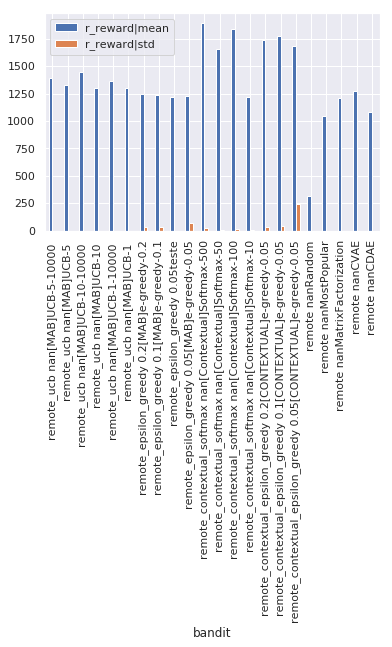

In [15]:
df_all[['r_reward|mean', 'r_reward|std']].plot(kind='bar')

In [16]:
#c = ['remote_ucb nan[MAB]UCB-1-10000	', 'remote_ucb nan[MAB]UCB-5-10000	', 'remote_ucb nan[MAB]UCB-10-10000	']
#df_all.loc[c].round(3)

In [17]:
df_all.to_csv("output/tmp/stats.csv", float_format='%.3f')

## Plot Results

In [18]:
df_models = list_bandits.set_index('name')[['model_list']]
df_models.index

Index(['remotenanCDAE', 'remotenanCVAE', 'remotenanMatrixFactorization',
       'remotenanMostPopular', 'remotenanRandom',
       'remote_contextual_epsilon_greedy0.05[CONTEXTUAL]e-greedy-0.05',
       'remote_contextual_epsilon_greedy0.1[CONTEXTUAL]e-greedy-0.05',
       'remote_contextual_epsilon_greedy0.2[CONTEXTUAL]e-greedy-0.05',
       'remote_contextual_softmaxnan[Contextual]Softmax-10',
       'remote_contextual_softmaxnan[Contextual]Softmax-100',
       'remote_contextual_softmaxnan[Contextual]Softmax-50',
       'remote_contextual_softmaxnan[Contextual]Softmax-500',
       'remote_epsilon_greedy0.05[MAB]e-greedy-0.05',
       'remote_epsilon_greedy0.05teste',
       'remote_epsilon_greedy0.1[MAB]e-greedy-0.1',
       'remote_epsilon_greedy0.2[MAB]e-greedy-0.2', 'remote_ucbnan[MAB]UCB-1',
       'remote_ucbnan[MAB]UCB-1-10000', 'remote_ucbnan[MAB]UCB-10',
       'remote_ucbnan[MAB]UCB-10-10000', 'remote_ucbnan[MAB]UCB-5',
       'remote_ucbnan[MAB]UCB-5-10000'],
      dtype='o

In [19]:



legend = {'remotenanCDAE': "CDAE", 
         'remotenanCVAE': "CVAE",  
         'remotenanMatrixFactorization': 'Matrix Factorization',
         'remotenanMostPopular': 'Most Popular',
         'remotenanMostPopularPerUser': 'Most Popular per User',
         'remotenanRandom': 'Random',
         'remote_contextual_epsilon_greedy[Contextual]e-greedy': 'Contextual e-greedy',
         'remote_contextual_softmax[Contextual]Softmax': 'Contextual Softmax',
         'remote_epsilon_greedy[MAB]e-greedy': 'e-greedy', 
         'remote_ucb[MAB]UCB': 'UCB',
         'remote_contextual_softmaxnan[Contextual]Softmax-10':'Meta-Bandit Softmax (10)', 
         'remote_contextual_softmaxnan[Contextual]Softmax-50':'Meta-Bandit Softmax (50)',
         'remote_contextual_softmaxnan[Contextual]Softmax-100':'Meta-Bandit Softmax (100)',
         'remote_contextual_softmaxnan[Contextual]Softmax-500':'Meta-Bandit Softmax (500)',
         'remote_contextual_epsilon_greedy0.05[CONTEXTUAL]e-greedy-0.05': 'Meta-Bandit e-greedy (0.05)',
         'remote_contextual_epsilon_greedy0.1[CONTEXTUAL]e-greedy-0.05': 'Meta-Bandit e-greedy (0.1)',
         'remote_contextual_epsilon_greedy0.2[CONTEXTUAL]e-greedy-0.05': 'Meta-Bandit e-greedy (0.2)',
         "remote_ucbnan[MAB]UCB-1-10000": "Meta-Bandit UCB (1)",                      
         "remote_ucbnan[MAB]UCB-10-10000": "Meta-Bandit UCB (10)",  
         "remote_ucbnan[MAB]UCB-5-10000": "Meta-Bandit UCB (5)",                            
        }

df_models.index = df_models.index.map(legend)
#df_models['model'] = df_models['bandit']
df_models.head(10)

,model_list
name,
CDAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6]
CVAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920]
Matrix Factorization,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b]
Most Popular,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a]
Random,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7]
Meta-Bandit e-greedy (0.05),"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______09ec6475d3, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______6d792a3ed1, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______afb131bbc0, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______675b43b6a5, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______2c656f2636, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______4184b0299f, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______a0d520e892]"
Meta-Bandit e-greedy (0.1),"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______5091adba5a, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______d08250e913, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______5c5906d549, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______8a7bb007f0, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______3ccb54e1a4, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______03a780dcaf, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______e0b5f34e99]"
Meta-Bandit e-greedy (0.2),"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______6e9c4bdd6a, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______5fc531976b, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______7ac2a172ad, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______43a64bfd00, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______f685f4e615, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______5afaccebb8, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______433956de17]"
Meta-Bandit Softmax (10),"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______3615524b61, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______0741e343b3, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______1b016623d3, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______924996f8b7, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c6345e61c1, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____

In [20]:
bandits           = legend.values()

sample_size       = 15000
window_size       = 1000 
bandits

dict_values(['CDAE', 'CVAE', 'Matrix Factorization', 'Most Popular', 'Most Popular per User', 'Random', 'Contextual e-greedy', 'Contextual Softmax', 'e-greedy', 'UCB', 'Meta-Bandit Softmax (10)', 'Meta-Bandit Softmax (50)', 'Meta-Bandit Softmax (100)', 'Meta-Bandit Softmax (500)', 'Meta-Bandit e-greedy (0.05)', 'Meta-Bandit e-greedy (0.1)', 'Meta-Bandit e-greedy (0.2)', 'Meta-Bandit UCB (1)', 'Meta-Bandit UCB (10)', 'Meta-Bandit UCB (5)'])

In [21]:
# df_metrics        = load_all_iteraction_metrics(input_iteraction, sample_size)

# df_metrics.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).rolling(window = window_size, min_periods=1).mean().reset_index(drop=True)

In [22]:
def load_dataset(df_models, bandits, sample_size):
    data = []
    for bandit in bandits:
        input_iteraction  = [p.split("/")[-1] for p in df_models.loc[bandit].model_list]
        df_metrics        = load_all_iteraction_metrics(input_iteraction, sample_size)
        #params            = load_iteractions_params2(input_iteraction)
        
        
        df        = load_all_iteraction_metrics(input_iteraction, sample_size)
        df['_idx'] = 1
        df_metrics                    = df.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).cumsum().reset_index()
        df_metrics['mean_reward']     = (df_metrics.reward/df_metrics._idx).fillna(0)
        df_metrics['mean_reward_win'] = df.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).rolling(window = window_size, min_periods=1).mean().reset_index(drop=True).reward

        df_metrics['bandit']      = bandit
        df_metrics['Model']       = bandit

        data.append(df_metrics)
    return pd.concat(data, ignore_index=True)
#
#    
#df_group = load_dataset(df_models, bandits, sample_size)
#df_group.tail()

In [23]:
#df_group['idx'].isin(df_group.idx.sample(200, random_state=41))

### Cumulative Reward

In [24]:
def plot_cum_reward(df, column='mean_reward', hue='bandit', legend=False, legend_extern=False, 
                    ylim=1, hue_order=None, y_axes=True, markersize=6):
    name = models[0].replace(" ", "_")
    #df = df[df.idx > 10]
    steps = int(df_group.idx.max()/25)
    idx   = [steps*i for i in range(steps)]    
    df = df[df.idx.isin(idx)]
    #df = df.sample(200, random_state=41)
    
    plt.figure()
    sns.set(style="darkgrid")
    sns.set(style="whitegrid", rc={"lines.scale_dashes": True, "lines.linewidth": 2.0})

    # Plot the responses for different events and regions
    ax =  sns.lineplot(x="idx", y=column, markers=markers, dashes=False, palette=palette,
                       style=hue, hue=hue, hue_order=hue_order, legend=legend,  data=df, markersize=markersize)
    ax.set_ylim(0,ylim)
    ax.set_yticks([0,500,1000,1500,2000])

    #ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward',fontsize=20)
    ax.tick_params(labelsize=11)
    ax.set_xlabel('Interactions',fontsize=15);
    if y_axes:
        ax.set_ylabel('Cumulative Reward',fontsize=15);
    else:
        ax.set_ylabel("")
    # Put the legend out of the figure
    if legend and legend_extern:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
    
    ax.grid(False)

    plt.savefig("output/tmp/plot_cum_reward_{}_{}_{}.pdf".format(name,legend,legend_extern) ,dpi=300, bbox_inches="tight")
    plt.show()

#### Cumulate Reward hyperparams

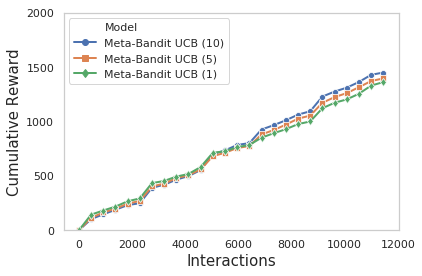

In [25]:
models = ["Meta-Bandit UCB (10)", "Meta-Bandit UCB (5)", "Meta-Bandit UCB (1)"]
palette = dict(zip(models, sns.color_palette("deep", 7)))
markers = dict(zip(models, ["o","s", "d", "P", "X",  "^", "v"]))

df_group = load_dataset(df_models, models, sample_size)
plot_cum_reward(df_group, column='reward', legend='full', hue='Model', hue_order=models, ylim=2000, y_axes=True)

In [26]:
models  = ['Meta-Bandit Softmax (500)', 'Meta-Bandit Softmax (100)',  
           'Meta-Bandit Softmax (50)', 'Meta-Bandit Softmax (10)']
palette = dict(zip(models, sns.color_palette("deep", 7)))
markers = dict(zip(models, ["o","s", "d", "P", "X",  "^", "v"]))


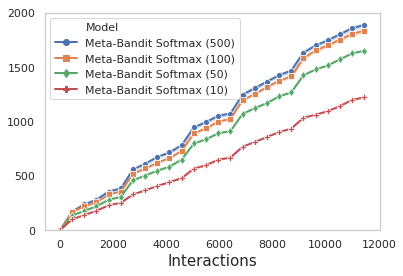

In [27]:
df_group = load_dataset(df_models, models, sample_size)
#df_group = df_group.groupby(['Model', 'idx']).median().reset_index()

plot_cum_reward(df_group, column='reward', legend='full', hue='Model', hue_order=models, ylim=2000, y_axes=False)

In [28]:
models  = ['Meta-Bandit e-greedy (0.1)', 'Meta-Bandit e-greedy (0.2)', 'Meta-Bandit e-greedy (0.05)']
palette = dict(zip(models, sns.color_palette("deep", 7)))
markers = dict(zip(models, ["o","s", "d", "P", "X",  "^", "v"]))


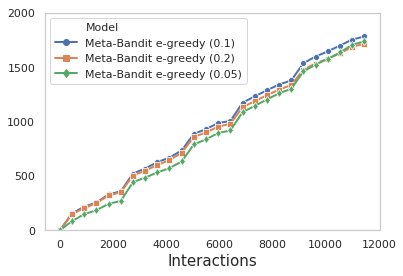

In [29]:
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).median().reset_index()

plot_cum_reward(df_group, column='reward', legend='full', hue='Model', hue_order=models, ylim=2000, y_axes=False)

#### Cumulate Reward Best Models

In [30]:
legend.values()

dict_values(['CDAE', 'CVAE', 'Matrix Factorization', 'Most Popular', 'Most Popular per User', 'Random', 'Contextual e-greedy', 'Contextual Softmax', 'e-greedy', 'UCB', 'Meta-Bandit Softmax (10)', 'Meta-Bandit Softmax (50)', 'Meta-Bandit Softmax (100)', 'Meta-Bandit Softmax (500)', 'Meta-Bandit e-greedy (0.05)', 'Meta-Bandit e-greedy (0.1)', 'Meta-Bandit e-greedy (0.2)', 'Meta-Bandit UCB (1)', 'Meta-Bandit UCB (10)', 'Meta-Bandit UCB (5)'])

In [31]:
models  = ['Meta-Bandit Softmax (500)',
           'Meta-Bandit UCB (10)', 'CVAE', 'CDAE', 
           'Matrix Factorization', 'Most Popular', 'Random']
palette = dict(zip(models, sns.color_palette("deep", 8)))

markers = dict(zip(models, ["o","s", "d", "P", "X",  "^", "v", "."]))


<Figure size 7200x36000 with 0 Axes>

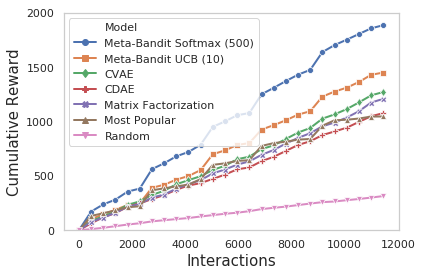

In [32]:

df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).median().reset_index()

plt.figure(figsize=(100, 500))
plot_cum_reward(df_group, column='reward', legend='full', hue='Model', hue_order=models, ylim=2000)

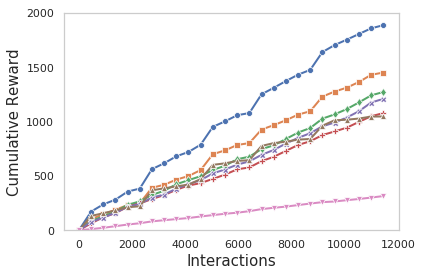

In [33]:
plot_cum_reward(df_group, column='reward', legend=False, hue='Model', 
                hue_order=models, ylim=2000, legend_extern=False)

### Cumulative Mean Reward

In [34]:
from matplotlib.colors import LogNorm
def plot_cum_mean_reward(df, column='mean_reward', hue='bandit', hue_order=None, 
                         legend=False, legend_extern=False, markersize=5,
                         ylim=1, title="plot_cum_mean_reward", palette=palette, figsize=None):
    #df = df.sample(200, random_state=41)

    steps = int(df_group.idx.max()/35)
    idx   = [steps*i for i in range(steps)]    
    df = df[df.idx.isin(idx)]
    
    plt.figure(figsize=figsize)
    sns.set(style="whitegrid", rc={"lines.scale_dashes": True, "lines.linewidth": 2.0})

    # Plot the responses for different events and regions
    ax =  sns.lineplot(x="idx", y=column, markers=markers, dashes=False, palette=palette,
                       style=hue, hue=hue, hue_order=hue_order, legend=legend, data=df, markersize=markersize)
    ax.set_ylim(0,ylim)
    #ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward',fontsize=20)
    ax.tick_params(labelsize=11)
    ax.set_yticks([0,0.1,0.2,0.3,0.4])
    ax.set_xlabel('Interactions',fontsize=15);
    ax.set_ylabel('Cumulative Mean Reward',fontsize=15);
    # Put the legend out of the figure
    if legend and legend_extern:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
    
    ax.grid(False)
    
    #ax.set_xticklabels(["1,", "2", "3", "4", "5", "6", "7"])
    
    plt.savefig("output/tmp/{}_{}_{}.pdf".format(title, legend, legend_extern),dpi=300, bbox_inches="tight")
    plt.show()


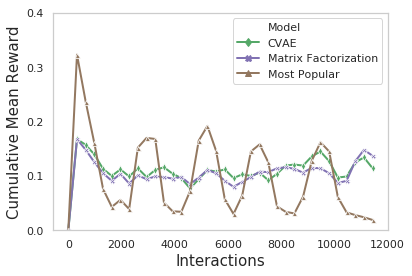

In [35]:
models  = ['CVAE', 'Matrix Factorization', 'Most Popular']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()
plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_models",
                     legend='full',hue_order=models, hue='Model', ylim=0.4)

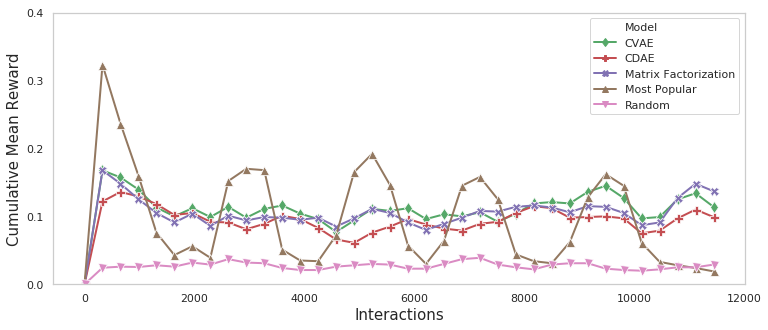

In [36]:
models  = ['CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()


plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_models",markersize=9,
                     legend='full',hue_order=models, hue='Model', ylim=0.4, figsize=(12.4, 5))

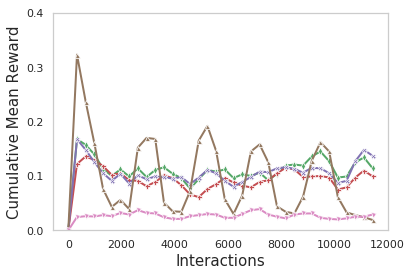

In [37]:
models  = ['CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()
plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_models_note_legend",
                     legend=False,hue_order=models, hue='Model', ylim=0.4)

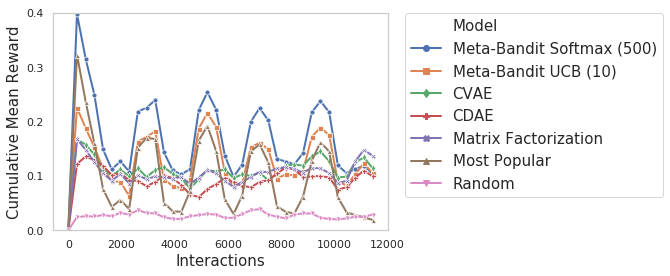

In [38]:
models  = ['Meta-Bandit Softmax (500)',
           'Meta-Bandit UCB (10)', 
           'CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()
plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_all_models_slim",
                     legend='full',hue_order=models, hue='Model', ylim=0.4, legend_extern=True)

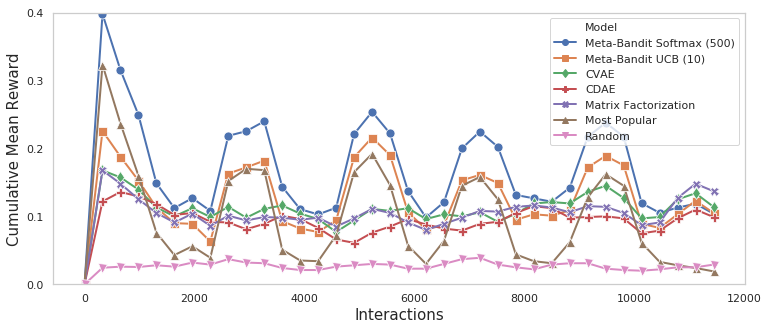

In [39]:
models  = ['Meta-Bandit Softmax (500)',
           'Meta-Bandit UCB (10)',
           'CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()

plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_all_models",markersize=9,
                     legend='full',hue_order=models, hue='Model', ylim=0.4, figsize=(12.4, 5))

In [40]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

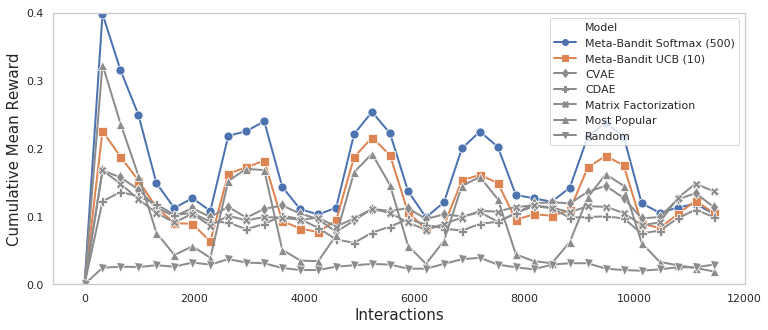

In [41]:
palette2 = {'Meta-Bandit Softmax (500)': (0.2980392156862745,
                                          0.4470588235294118,
                                          0.6901960784313725),
             'Meta-Bandit UCB (10)': (0.8666666666666667,
                                          0.5176470588235295,
                                          0.3215686274509804),
             'CVAE': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'CDAE': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'Matrix Factorization': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'Most Popular': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'Random': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)}

models  = ['Meta-Bandit Softmax (500)',
           'Meta-Bandit UCB (10)',
           'CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()


plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_all_models_fade",markersize=9,
                     legend='full',hue_order=models, hue='Model', ylim=0.4, figsize=(12.4, 5), palette=palette2)

In [42]:
palette2 = {'Meta-Bandit Softmax (500)': (0.2980392156862745,
                                          0.4470588235294118,
                                          0.6901960784313725),
             'Meta-Bandit UCB (10)': (0.8666666666666667,
                                          0.5176470588235295,
                                          0.3215686274509804),
             'CVAE': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'CDAE': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'Matrix Factorization': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'Most Popular': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'Random': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)}

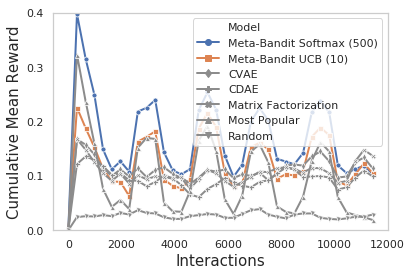

In [43]:
models  = ['Meta-Bandit Softmax (500)',
           'Meta-Bandit UCB (10)',
           'CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()
plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_all_models_fade",
                     legend='full',hue_order=models, hue='Model', ylim=0.4, palette=palette2)

## Explorer Bandit 

In [44]:
import pandas as pd
import pickle
import re
import sys
import numpy as np
import streamlit as st
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
import os
import seaborn as sns
import plotly.express as px

In [45]:
bandits  = ['Meta-Bandit e-greedy (0.1)', 'Meta-Bandit Softmax (500)', 'Meta-Bandit UCB (10)']
df_group = load_dataset(df_models, bandits, sample_size)
df_group.tail()

df_plot = df_group.sort_values('reward').groupby('bandit').last().reset_index()
df_plot

,bandit,iteraction,idx,user,item,reward,index_env,_idx,mean_reward,mean_reward_win,Model
0,Meta-Bandit Softmax (500),EnsambleMABInteraction____remote_contextua___endpoints______83cc906d2c,11472,2731788585,41576972,1928.0,65809128,11473,0.168047,0.105,Meta-Bandit Softmax (500)
1,Meta-Bandit UCB (10),EnsambleMABInteraction____remote_ucb___endpoints______c6ad4386c3,11471,2731406796,48558681,1452.0,65797656,11472,0.126569,0.096,Meta-Bandit UCB (10)
2,Meta-Bandit e-greedy (0.1),EnsambleMABInteraction____remote_contextua___endpoints______03a780dcaf,11472,2731788585,41693040,1846.0,65809128,11473,0.160900,0.107,Meta-Bandit e-greedy (0.1)


In [46]:
import gc
gc.collect()

12953

In [47]:
import pickle
def load_bandit(iteraction):
    path = '/media/workspace/DeepFood/deep-reco-gym/output/interaction/EnsambleMABInteraction/results/{}/'.format(iteraction)
    bandit = pickle.load(open(path+"/"+"bandit.pkl", "rb"))
    return bandit
bandit = load_bandit(df_plot.iloc[0].iteraction)

In [48]:
def get_arms(bandit):
    arms    = np.unique(bandit._arms_selected)
    arms_rewards = bandit._arms_selected
    rounds  = len(bandit._arms_selected)
    count_per_arms = {}

    for a in arms:
        count_per_arms[a] = np.zeros(rounds)


    for r in range(rounds):
        count_per_arms[arms_rewards[r]][r] = 1

    return count_per_arms

In [49]:
count_per_arms = get_arms(bandit)
count_per_arms

{0: array([0., 0., 1., ..., 1., 0., 1.]),
 1: array([1., 0., 0., ..., 0., 0., 0.]),
 2: array([0., 1., 0., ..., 0., 1., 0.]),
 3: array([0., 0., 0., ..., 0., 0., 0.])}

In [50]:
def stack_values(count_per_arms, window = 1000):

    values = count_per_arms[0]

    arm1 = pd.Series(count_per_arms[0]).rolling(window = window, min_periods=1).mean()
    arm2 = pd.Series(count_per_arms[1]).rolling(window = window, min_periods=1).mean()
    arm3 = pd.Series(count_per_arms[2]).rolling(window = window, min_periods=1).mean()
    arm4 = pd.Series(count_per_arms[3]).rolling(window = window, min_periods=1).mean()

    data = pd.DataFrame({'arm1': arm1, 'arm2': arm2, 'arm3': arm3, 'arm4': arm4})
    return data

data = stack_values(count_per_arms, window = 1000)

In [51]:
bandit._endpoints

('http://localhost:5001/rank',
 'http://localhost:5003/rank',
 'http://localhost:5004/rank',
 'http://localhost:5005/rank')

In [52]:
palette

{'Meta-Bandit Softmax (500)': (0.2980392156862745,
  0.4470588235294118,
  0.6901960784313725),
 'Meta-Bandit UCB (10)': (0.8666666666666667,
  0.5176470588235295,
  0.3215686274509804),
 'CVAE': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 'CDAE': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 'Matrix Factorization': (0.5058823529411764,
  0.4470588235294118,
  0.7019607843137254),
 'Most Popular': (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 'Random': (0.8549019607843137, 0.5450980392156862, 0.7647058823529411)}

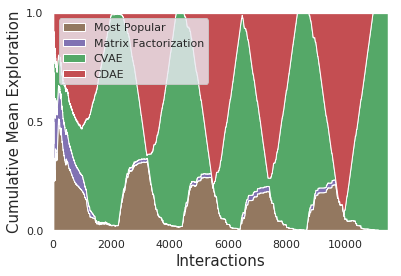

In [53]:
def plot_exploration(data, title = "exploration_fig.pdf", 
                     labels=['Most Popular', 'Matrix Factorization','CVAE', 'CDAE'], y_axes=True, legend=True):

    colors=[palette[l] for l in labels]
    #models  = ['CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
    plt.figure()

    sns.set(style="darkgrid")
    plt.xlabel('Interactions', fontsize=15)
    

    if y_axes:
        plt.ylabel('Cumulative Mean Exploration', fontsize=15)
    else:
        plt.ylabel('', fontsize=15)
        
    # We need to transform the data from raw data to percentage (fraction)
    data_perc = data.divide(data.sum(axis=1), axis=0)

    # Make the plot
    plt.stackplot(range(len(data)),  data_perc["arm1"],  data_perc["arm2"],  
                  data_perc["arm3"],  data_perc["arm4"], labels=labels, colors=colors)
    if legend:
        plt.legend(loc='upper left')
    plt.margins(0,0)
    plt.yticks([0,0.5,1])

    plt.tick_params(labelsize=11)

    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
    plt.savefig("output/tmp/{}.pdf".format(title),dpi=300, bbox_inches="tight")
    plt.show()
    
plot_exploration(data)

### Plot

Meta-Bandit Softmax (500)


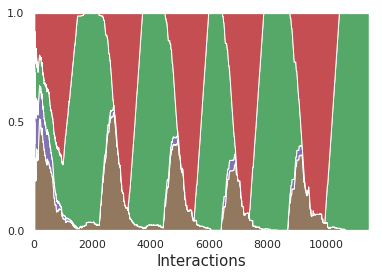

In [54]:
model  = df_plot.iloc[0]
print(model.Model)
bandit = load_bandit(model.iteraction)
count_per_arms = get_arms(bandit)
data = stack_values(count_per_arms, window = 500)
plot_exploration(data, legend=False, y_axes=False, title = "exploration_fig_{}.pdf".format(model.bandit.replace(" ", "_")))

In [55]:
## 

Meta-Bandit UCB (10)


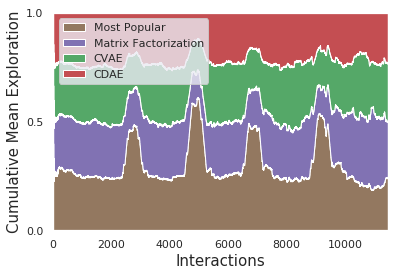

In [56]:
model  = df_plot.iloc[1]
print(model.Model)

bandit = load_bandit(model.iteraction)
count_per_arms = get_arms(bandit)
data = stack_values(count_per_arms, window = 500)
plot_exploration(data, title = "exploration_fig_{}.pdf".format(model.bandit.replace(" ", "_")))

Meta-Bandit e-greedy (0.1)


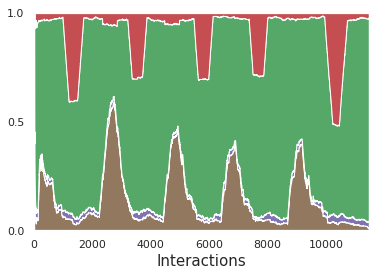

In [57]:
model  = df_plot.iloc[2]
print(model.Model)
bandit = load_bandit(model.iteraction)
count_per_arms = get_arms(bandit)
data = stack_values(count_per_arms, window = 500)
plot_exploration(data, legend=False, y_axes=False, title = "exploration_fig_{}.pdf".format(model.bandit.replace(" ", "_")))